7/21/2024\
Author: Michael Stoll\
\
This assignment is going to look a lot like the HPO assignment. The only real change that you will notice is the addition of the preprocessing steps in both the search cells and the search space cell. I will point them out when we get to that point.\
\
As was the objective previously, I am in search of the set of hyperparameters that leads to the regressor with the higest r-squared score. That set is now expanded to include the parameters for each of the preprocessing tools I've used as well.\
\
For the sake of keeping things simple, I've elected to stick with the red wine quality data set. This being (likely) the last time I'm going to look at this particular dataset, I'd like to take the opportunity to lament the lack of brand names or other identifying marks. I know it must be to maintain anonymity but it would be nice to be able to use ML to find the next brand I'm going to try. I digress.

In [12]:
import numpy as np
import pandas as pd

data = pd.read_csv("winequality-red.csv", sep=",")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


As I am in the habit of doing, I'd like to show a correlation map now, just as a refresher of how the different features and the target correlate with one another.

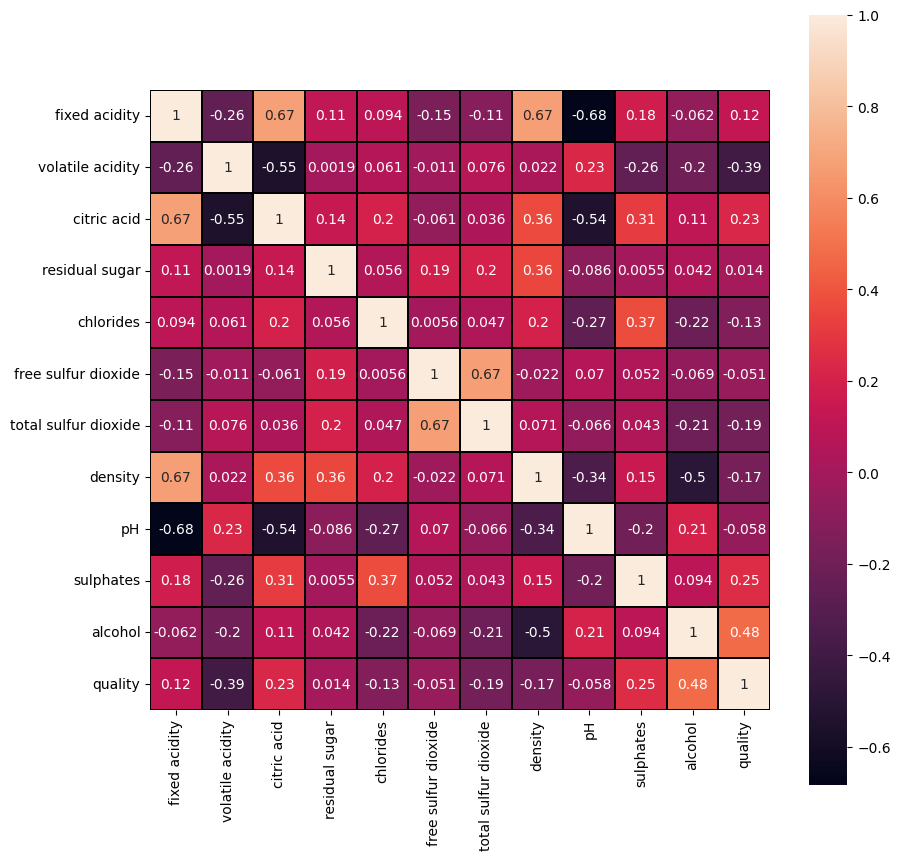

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square = True, annot=True, annot_kws={'fontsize':10}, linewidths=.1, vmax=1, linecolor='black')
plt.show()

Now it's time to get specific about what I consider to be the target. This time, I'd like to mix it up a bit and select a different target. Since it would be nice to see a strong model for once, I'm going to choose fixed acidity, because it has the most strong correlations with other features.

In [14]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=['fixed acidity'])
target = data['fixed acidity']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.3, random_state= 264)

Before we can do any searching there need to be spaces in which to search. I've chosen a few hyperparameters from each of the regressors I'm using (support vector, gradient boosting, random forest, and decision tree), and additionally the hyperparameters for all of the preprocessing methods. The number of parameters used is displayed in the graph below this cell.\
\
This feels like a good time to explain my choices. For the sake of preprocessing this dataset, I've chosen the MinMaxScaler, the Normalizer, and the PowerTransformer.\
\
The MinMaxScaler just scales the values to fit within a given range. The default for this given range is (0,1), and I decided not to change that, because it felt like unnecessary complexity to add to this already expensive operation. The scaled values are floating point numbers, meaning we still have the same accuracy of conversion between 0 and 1 as we would between 0 and 100. I did, however, choose to add the hyperparameters 'copy' (a boolean value that determines whether the data is copied to a new array or if the scaling is done inplace) and 'clip' (a boolean that decides whether or not transformed values of held-out data are clipped to the provided feature range), since I felt that both of those would be significant, if not in accuracy then in runtime.\
The reason I chose this specific scaler over the others that were available was because I thought that there might be some loss of accuracy with the combination of integers and floating point numbers in the features, so I wanted to work on a singular, consistent scale.\
\
Next is the Normalizer, which rescales each sample vector to have unit norm, depending on which value of norm is used. 'l1' norm is the sum of the absolute values of a vector, 'l2' is the squared root of the sum of a vector, and 'max' is the maximum value of a vector. The idea here is basically to mitigate the occurrence of outliers by ensuring that each vector has a similar norm.\
\
Finally, the PowerTransformer. This method applies a power transform to each feature to make the data more Gaussian in nature, which is useful when the variance between different instances is non-constant (as is the case in this dataset) because it reduces that variability. In the next cell, you'll notice that I've hardcoded the 'method' parameter to be 'yeo-johnson' instead of allowing it to choose between that and 'box-cox'. The reason for this is that the 'box-cox' transformation does not accept negative values, and apparently some exist in this dataset. Who knew. The parameter that is up for optimization is 'standardize', which is just a boolean that determines whether or not zero-mean unit-variance normalization is applied to the transformed output.\
\
Also worth mentioning is the prefix on each of these attributes. This will make more sense in the next step, but the basic idea is that this allows the attributes to go to only the correct augmenting function.

In [34]:
#build search spaces
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate


copy = [True, False]
clip = [True, False]

norm = ['l1', 'l2', 'max']

standardize = [True, False]

estimators = list(range(300,900))
maxFeatures = ['sqrt', 'log2', None]
minSplit = list(range(2,20))
minLeaf = list(range(1,5))
randomGrid = {'scaler__copy':copy, 'scaler__clip':clip,'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__n_estimators':estimators, 'regressor__max_features':maxFeatures, 'regressor__min_samples_split':minSplit, 'regressor__min_samples_leaf':minLeaf}

maxIter = list(range(300,900))
gamma = ['scale', 'auto']
degree = list(range(3,16))

svcGrid = {'scaler__copy':copy, 'scaler__clip':clip, 'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__max_iter':maxIter, 'regressor__gamma':gamma, 'regressor__degree':degree}

splitter = ['best', 'random']
maxDepth = list(range(40,115))
dtGrid = {'scaler__copy':copy, 'scaler__clip':clip, 'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__splitter':splitter, 'regressor__max_depth':maxDepth, 'regressor__min_samples_split':minSplit, 'regressor__min_samples_leaf':minLeaf}

gbGrid = {'scaler__copy':copy, 'scaler__clip':clip, 'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__max_depth':maxDepth, 'regressor__max_features':maxFeatures, 'regressor__min_samples_leaf':minLeaf, 'regressor__min_samples_split':minSplit}

space = [svcGrid, dtGrid, gbGrid, randomGrid]
models = [SVR(), DecisionTreeRegressor(), GradientBoostingRegressor(),RandomForestRegressor()]

searchSpaces = [['Attribute Name', 'Attribute Range'] + models, 
                ['n_estimators', '(300-900)', '', '', '', '600'],
                ['splitter', '(Best, Random)', '', '2', '', ''],
                ['max_depth', '(40-115)', '', '75', '75', ''],
                ['min_samples_split', '(2-20)', '', '18', '18', '18'],
                ['min_samples_leaf', '(1-5)','', '5', '5', '5'],
                ['max_features', '(sqrt, log2, None)','', '', '3', '3'],
                ['gamma', '(Scale, Auto)', '2', '', '', ''],
                ['max_iter', '(300-900)', '600', '', '', ''],
                ['degree', '(3-16)', '13', '', '', ''],
                ['copy', '(True, False)', '2', '2', '2', '2'],
                ['clip', '(True, False)', '2', '2', '2', '2'],
                ['norm', '(l1, l2, max)', '3', '3', '3', '3'],
                ['standardize', '(True, False)', '2', '2', '2', '2'],
                ['', 'Total Combos:', 2*13*600*2*2*2*3*3, 2*75*18*5*2*2*2*3, 75*18*5*3*2*2*2*3, 600*18*5*3*2*2*2*3]]
print(tabulate(searchSpaces, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════╤════════════════════╤═════════╤═══════════════════════════╤═══════════════════════════════╤═══════════════════════════╕
│ Attribute Name    │ Attribute Range    │ SVR()   │ DecisionTreeRegressor()   │ GradientBoostingRegressor()   │ RandomForestRegressor()   │
╞═══════════════════╪════════════════════╪═════════╪═══════════════════════════╪═══════════════════════════════╪═══════════════════════════╡
│ n_estimators      │ (300-900)          │         │                           │                               │ 600                       │
├───────────────────┼────────────────────┼─────────┼───────────────────────────┼───────────────────────────────┼───────────────────────────┤
│ splitter          │ (Best, Random)     │         │ 2                         │                               │                           │
├───────────────────┼────────────────────┼─────────┼───────────────────────────┼───────────────────────────────┼───────────────────────────┤
│ max_depth  

This is simply a function to abstract a bit of the code from the search, for the sake of sanity.

In [16]:
def build(model, opt):
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    if(not opt):
        return pred
    else:
        return model

This is the part where I put it all together. Believe it or not, the way that you pipeline optimization in python is by using a built-in utility called Pipeline. Who knew?\
\
The idea here is that the data starts at one end of the pipeline and then is passed through each preprocessing function, transforming as it goes. Then, when it hits the end, the final passed parameter (a regressor, in this case) is augmented by the various preprocessing changes. Then the search behaves exactly as it always does, trying different hyperparameters in the function until it runs out of iterations.

In [17]:
from time import time #I want to know how long they take
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, PowerTransformer
import warnings
warnings.filterwarnings("ignore")

randScore = 0
randName = ''
randParams = ''
randBest = ''
randTime = 0
i = 0
for model in models:
    currentTime = time()

    search = RandomizedSearchCV(Pipeline([(('scaler', MinMaxScaler())), ('normalizer', Normalizer()), ('transformer', PowerTransformer(method='yeo-johnson')), ('regressor', model)]), 
                                space[i], n_iter=30, scoring='r2', n_jobs=-1, cv=4)
    mean = cross_val_score(search, features, target, scoring='r2', cv=3).mean()
    print(f"average r2 score: {mean}")
    i = i + 1
    totalTime = time() - currentTime
    print(f"{model} took {totalTime}.\n")
    if(mean > randScore):
        randScore = mean
        randName = model
        randTime = totalTime
        randBest = build(search, True)
        randParams = randBest.best_params_

print(f"\nThe best performing model was {randName} with the params {randParams} and an r2 score of {randScore}.")


average r2 score: 0.7843301239617076
SVR() took 20.565069437026978.

average r2 score: 0.5471707603269204
DecisionTreeRegressor() took 7.398316144943237.

average r2 score: 0.7167794779488007
GradientBoostingRegressor() took 114.08188104629517.

average r2 score: 0.7316762944268539
RandomForestRegressor() took 803.943553686142.


The best performing model was SVR() with the params {'transformer__standardize': True, 'scaler__copy': True, 'scaler__clip': True, 'regressor__max_iter': 379, 'regressor__gamma': 'scale', 'regressor__degree': 11, 'normalizer__norm': 'l1'} and an r2 score of 0.7843301239617076.


Two things about this were surprising to me. The first was the sheer increase in time complexity (for context, 1000 iterations only takes me 7 minutes without preprocessing, while 30 iterations apparently takes almost 16 cummulative minutes). The second was that SVR had the highest accuracy. In every other experiment I've run with it, its accuracy has been somewhere in the low (sometimes even negative) single digits. Apparently, after preprocessing, it's the most accurate model I have.\
\
To show you what I mean, I'm going to compare the results I've just seen with the results of a default SVR running on the same data. That's what most of this is, the rest of it is gathering information for a later step.

r2 for default: 0.04291707170335801
r2 for optimized: 0.8496508366813667


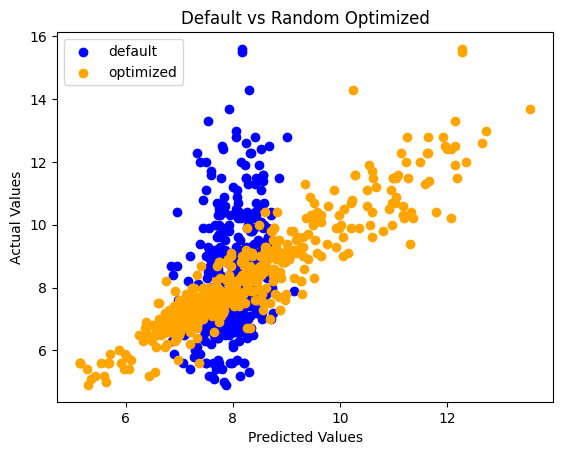

In [35]:
from sklearn.metrics import r2_score

start = time()
word = randName.fit(features_train, target_train)
defaultMean = cross_val_score(word, features, target, cv = 15).mean()
defaultTime = time() - start

rPred = randBest.predict(features_test)
dPred = word.predict(features_test)

print("r2 for default: " + str(r2_score(target_test, dPred)))
print("r2 for optimized: " + str(r2_score(target_test, rPred)))

plt.scatter(dPred, target_test, color='blue', label="default")
plt.scatter(rPred, target_test, color='orange', label="optimized")
plt.legend(loc="upper left")
plt.title("Default vs Random Optimized")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Clearly the difference is night and day in accuracy. I guess there might be some value in preprocessing after all.\
\
For posterity, I find it important to run a Bayesian search as well to compare results.

In [25]:
#bayesian opt
from skopt import BayesSearchCV

bayesScore = 0
bayesName = ""
bayesParams = ""
bayesTime = 0
bayesBest = ""
i = 0
for model in models:
    currentTime = time()

    search = BayesSearchCV(Pipeline([(('scaler', MinMaxScaler())), ('normalizer', Normalizer()), ('transformer', PowerTransformer(method='yeo-johnson')), ('regressor', model)]), 
                                space[i], n_iter=30, scoring='r2', n_jobs=-1, cv=4)
    mean = cross_val_score(search, features, target, scoring='r2', cv=3).mean()
    print(f"average r2 score: {mean}")
    i = i + 1
    totalTime = time() - currentTime
    print(f"{model} took {totalTime}.\n")
    if(mean > bayesScore):
        bayesScore = mean
        bayesName = model
        bayesBest = build(search,True)
        bayesParams = bayesBest.best_params_
        bayesTime = totalTime
        

print(f"\nThe best performing model was {bayesName} with the parameters {bayesParams} and a mean accuracy of {bayesScore}.")

average r2 score: 0.7780864761581254
SVR() took 1666.8743295669556.

average r2 score: 0.601004007052309
DecisionTreeRegressor() took 802.1159417629242.

average r2 score: 0.7143071764254882
GradientBoostingRegressor() took 1282.683754682541.

average r2 score: 0.7300550588020864
RandomForestRegressor() took 5667.673648118973.


The best performing model was SVR() with the parameters OrderedDict({'normalizer__norm': 'l2', 'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__max_iter': 673, 'scaler__clip': True, 'scaler__copy': False, 'transformer__standardize': True}) and a mean accuracy of 0.7780864761581254


As before, SVR shows the highest accuracy. Let's see how it compares to that default model.

r2 for default: 0.04291707170335801
r2 for optimized: 0.8550315478192893


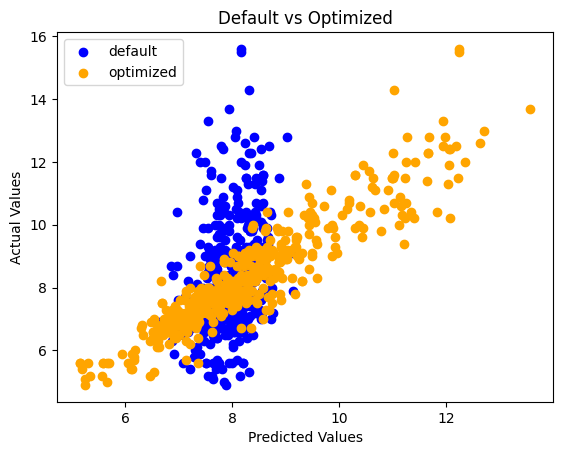

In [26]:
from sklearn.metrics import r2_score

bPred = bayesBest.predict(features_test)

print("r2 for default: " + str(r2_score(target_test, dPred)))
print("r2 for optimized: " + str(r2_score(target_test, bPred)))

plt.scatter(dPred, target_test, color='blue', label="default")
plt.scatter(bPred, target_test, color='orange', label="optimized")
plt.legend(loc="upper left")
plt.title("Default vs Optimized")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

That's pretty much what we saw last time. In fact, even the outliers appear to be in basically the same spot. Let's look at them on top of one another to see what contributes to that ~1% difference in r-squared score.

r2 for random: 0.8496508366813667
r2 for Bayesian: 0.8550315478192893


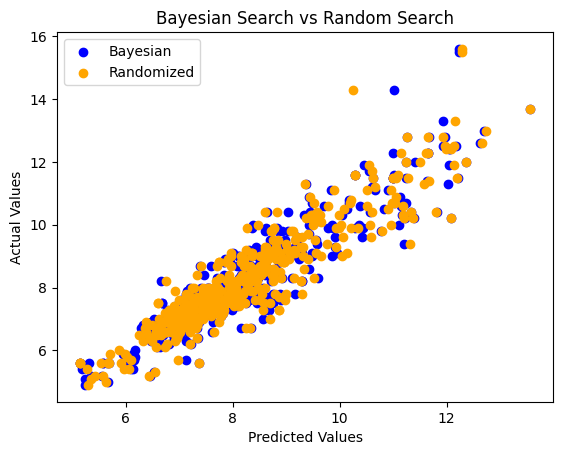

In [29]:
rScore = r2_score(target_test, rPred)
bScore = r2_score(target_test, bPred)

print(f"r2 for random: {rScore}")
print(f"r2 for Bayesian: {bScore}")

plt.scatter(bPred, target_test, color='blue', label="Bayesian")
plt.scatter(rPred, target_test, color='orange', label="Randomized")
plt.legend(loc="upper left")
plt.title("Bayesian Search vs Random Search")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

It really is remarkable how similar that is. Now let's get really specific about comparing the inputted hyperparameters in each scenario.

In [36]:

default = {'transformer__standardize':True, 'scaler__copy':True, 'scaler__clip':False, 'regressor__max_iter':'No Limit', 'regressor__gamma':'scale', 'regressor__degree':3, 'normalizer__norm':'l2', 'scaler__feature_range':(0,1)}

results = [['Param Name', 'Default', 'Random', 'Bayesian']]
for attribute in randParams:
    #print(str(attribute))
    results = results + [[attribute, str(default[attribute]), str(randParams[attribute]), str(bayesParams[str(attribute)])]]
results = results + [['r2 score', defaultMean, str(rScore), str(bScore)]]
results = results + [['Runtime', defaultTime, str(randTime), str(bayesTime)]]
print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════════╤═════════════════════╤════════════════════╤════════════════════╕
│ Param Name               │ Default             │ Random             │ Bayesian           │
╞══════════════════════════╪═════════════════════╪════════════════════╪════════════════════╡
│ transformer__standardize │ True                │ True               │ True               │
├──────────────────────────┼─────────────────────┼────────────────────┼────────────────────┤
│ scaler__copy             │ True                │ True               │ False              │
├──────────────────────────┼─────────────────────┼────────────────────┼────────────────────┤
│ scaler__clip             │ False               │ True               │ True               │
├──────────────────────────┼─────────────────────┼────────────────────┼────────────────────┤
│ regressor__max_iter      │ No Limit            │ 379                │ 673                │
├──────────────────────────┼─────────────────────┼────────────────────

The results for the parameters show clear trends in some directions, such as the max number of iterations increasing and the standardization staying stagnant.\
The bottom two rows are far more telling. As you move from Default to Bayesian, the r-squared score increases quite significantly. So too does the runtime, at least on my machine. The question of which one is best is a bit complicated here, since it really becomes an argument of time complexity versus accuracy. The Bayesian optimized score is clearly the highest, but is it really worth running over 80 times longer than the random optimization? For the sake of this assignment, I will say yes, since the point was to find the best predictor, not the fastest. If I wanted the fastest I suppose I would have worked with the default parameters, even with that abyssmal r-squared score.